In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
notation = 'pyrimidine'

buffalo = 'B:/'
hg38_path = '{}hg38/hg38.fa'.format(buffalo)
exome_file = '{}ASTD/9606_exons.fa'.format(buffalo)
cosmic_mutants = '{}cosmic/v76/CosmicMutantExport_LiverHCC.tsv'.format(buffalo)

aflatoxin_cluster_names = ['067T', '3206A7_009_T', '3206A7_017_T',
                           'CHC1154T' 'CHC1211T', 'CHC1704T', 'CHC1717T', 'CHC1754T',
                           'TCGA-CC-A7IG-01', 'TCGA-CC-A7II-01', 'TCGA-CC-A7IL-01',
                           'TCGA-DD-A114-01', 'TCGA-DD-A1EL-01']

stratton_cluster = ['CHC1154T', 'CHC1211T',  'CHC1704T', 'CHC1717T', 'CHC1754T',
                    'TCGA-CC-A5UE-01', 'TCGA-CC-A7IG-01', 'TCGA-CC-A7II-01',
                    'TCGA-CC-A7IL-01', 'TCGA-DD-A114-01', 'TCGA-DD-A1EL-01']

Load Human Genome into Memory for Fast Random Access
---

In [171]:
from varsig.utils import fasta_to_dict

hg38 = fasta_to_dict(hg38_path)

Generate HCC Samples and Merge based on Name and Set Trinucleotide Context and Spectrum
---

In [179]:
from varsig.spectrum import Spectrum
from cosmicpy.utils import parse_to_samples, merge_samples

merged_samples = merge_samples(parse_to_samples(cosmic_mutants))

for sample in merged_samples.values():
    sample.spectrum = Spectrum(notation=notation)
    for mutation in sample.mutations:
        mutation.set_context(hg38, notation=notation)
        if mutation.label is not '':
            sample.spectrum[(mutation.label[2:5], mutation.context)] += 1
del hg38

Find Exome Normalization
---

In [22]:
from skbio import DNA, io
from collections import Counter
from varsig.utils import purines

exon_normal = Counter()

for seq in io.read(exome_file, format='fasta'):
    for kmer, count in seq.kmer_frequencies(3, overlap=True).items():
        kmer = str(DNA(kmer).reverse_complement()) if kmer[1] in purines else kmer
        exon_normal[kmer] += count

KeyboardInterrupt: 

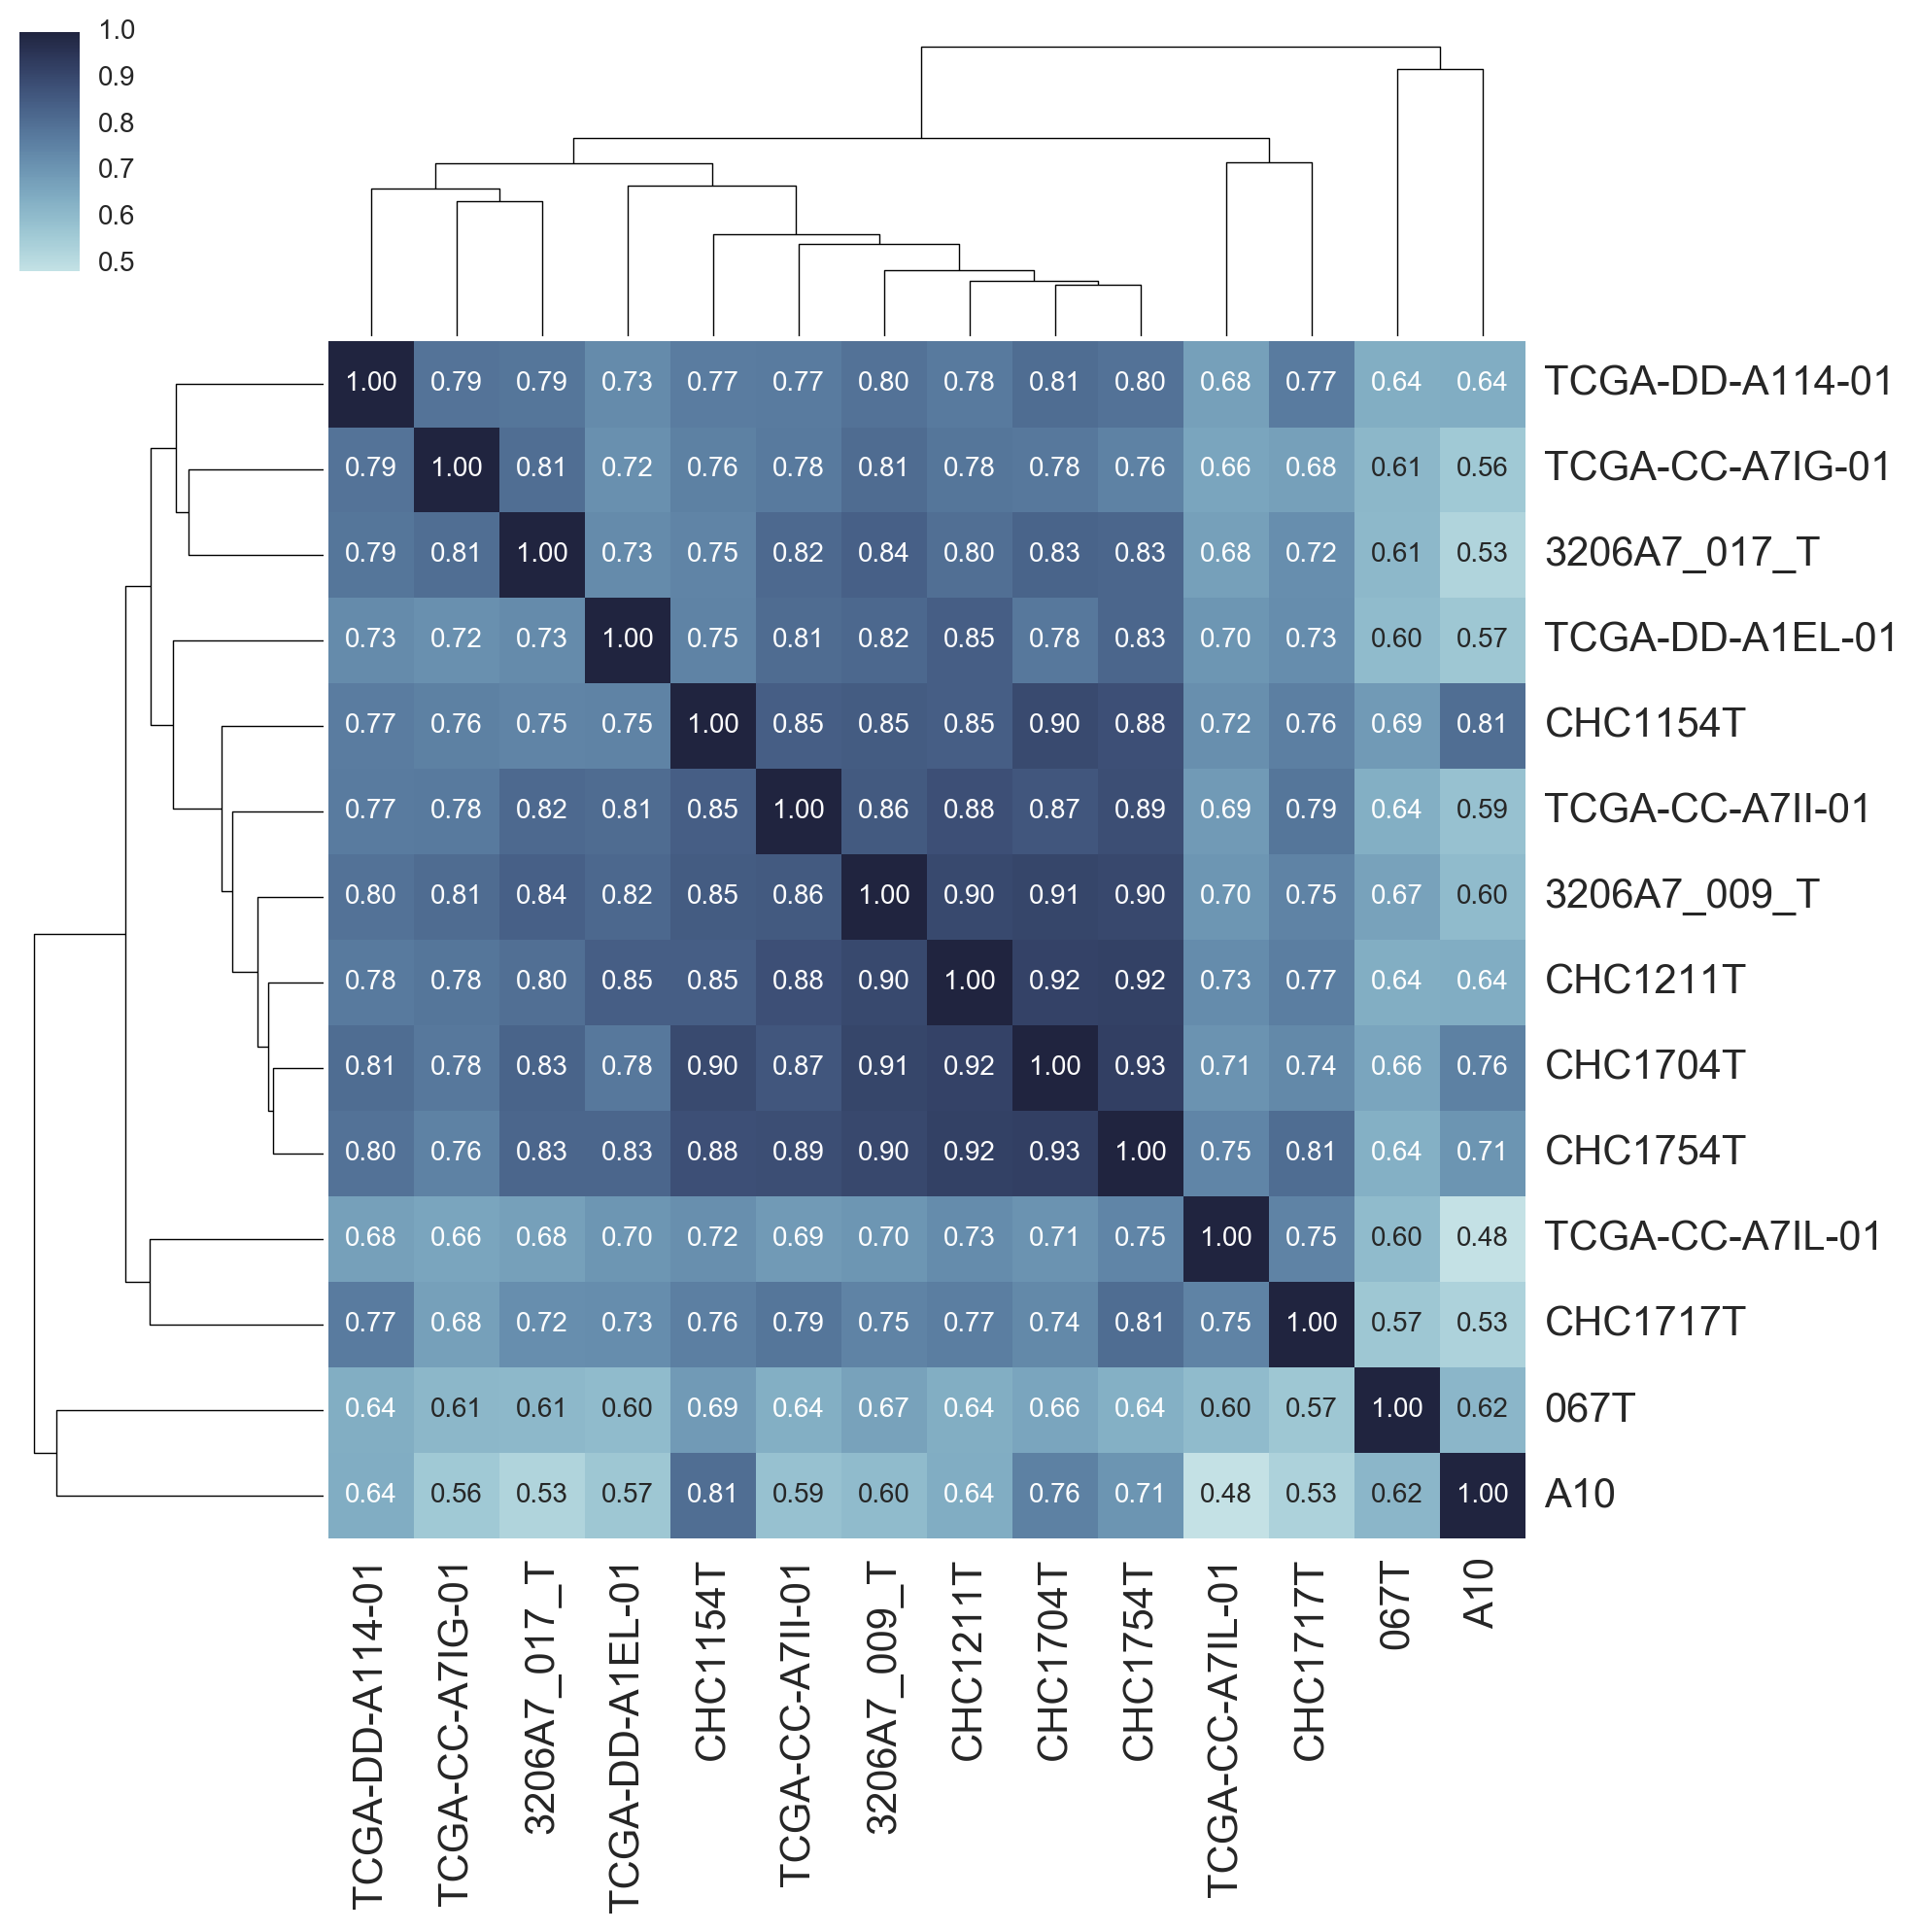

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from varsig.data import A10
from fastcluster import linkage
from sklearn.metrics.pairwise import cosine_similarity

spectra = [list(merged_samples[name].spectrum.normalized_proportion(exon_normal)) for name in aflatoxin_cluster_names] + [A10]

linkages = linkage(spectra, method='weighted', metric='cosine')
with plt.rc_context({'lines.linewidth': 1.25}):
    grid = sns.clustermap(pd.DataFrame(cosine_similarity(spectra),
                                       columns=aflatoxin_cluster_names + ['A10'],
                                       index=aflatoxin_cluster_names  + ['A10']),
                          method='weighted',
                          row_cluster=True, col_cluster=True,
                          row_linkage=linkages, col_linkage=linkages,
                          annot=True, fmt='.2f',
                          cmap=sns.cubehelix_palette(start=9, rot=-0.2, dark=0.15, light=.85, as_cmap=True))

_ = grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), size=15)
_ = grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), size=15, rotation=0)

#plt.savefig('heatmap.pdf', dpi=450, bbox_inches='tight')

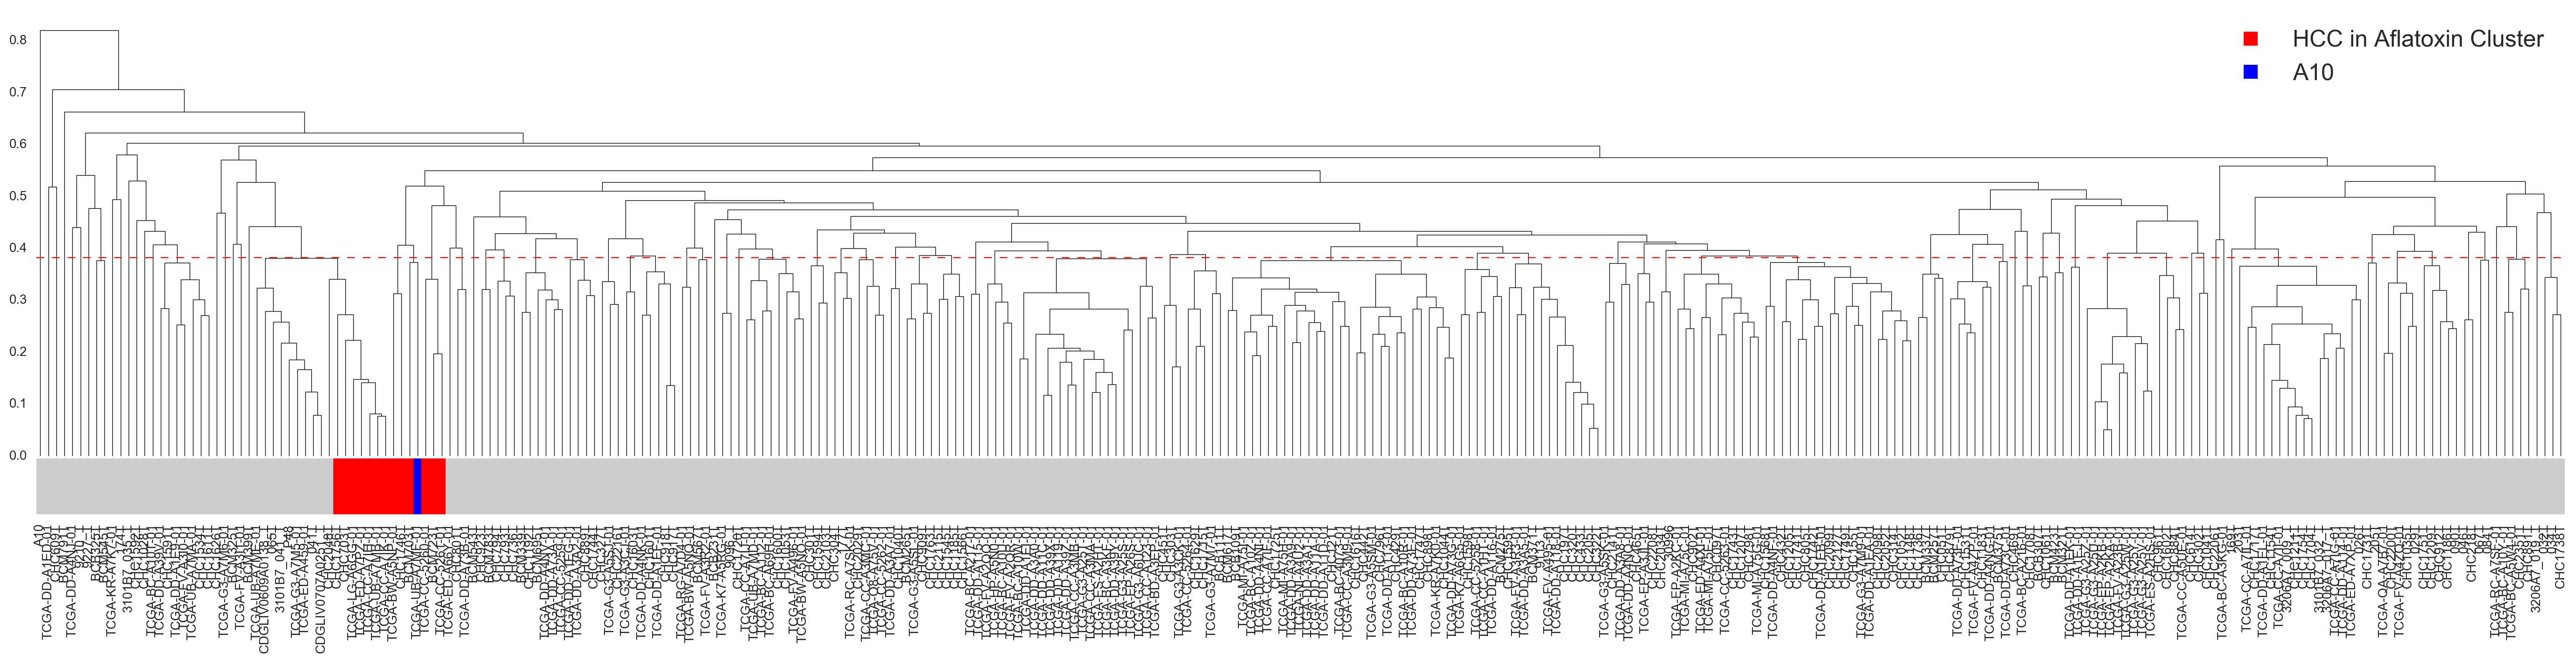

In [183]:
from scipy.cluster.hierarchy import dendrogram
from varsig.figures import colored_bins, despine

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 7), gridspec_kw={'height_ratios': [8,1], 'hspace': 0.01})

cut = 0.3825
selected_samples = [sample for sample in merged_samples.values() if 100 <= len(sample.mutations) < 8000]
data, labels = zip(*[(list(sample.spectrum.normalized_proportion(exon_normal)), sample.name) for sample in selected_samples])

with plt.rc_context({'lines.linewidth': 0.5}):
    den = dendrogram(linkage(pd.DataFrame(list(data) + [A10], index=list(labels) + ['A10']),
                             method='weighted',
                             metric='cosine'),
                     ax=despine(ax1),
                     no_labels=True,
                     labels=df.index,
                     link_color_func=lambda x: 'k')
    ax1.axhline(cut, color='red', lw=0.8, ls='--')

colored_bins(len(den['ivl']),
             ax=despine(ax2),
             colors=['b' if i == 47 else 'r' if 36 < i < 51 else '0.8' for i in range(len(den['ivl']))],
             labels=den['ivl'])

ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=90)

legend = ax1.legend([plt.Line2D((0,1),(0,0), color='red', marker='s', ms=13, ls=''),
                     plt.Line2D((0,1),(0,0), color='blue', marker='s', ms=13, ls='')],
                    ['HCC in Aflatoxin Cluster', 'A10'],
                    prop={'size': 18})

#plt.savefig('cluster.pdf', dpi=600)
print("Number of HCC: {}".format(len(den['ivl']) - 1))

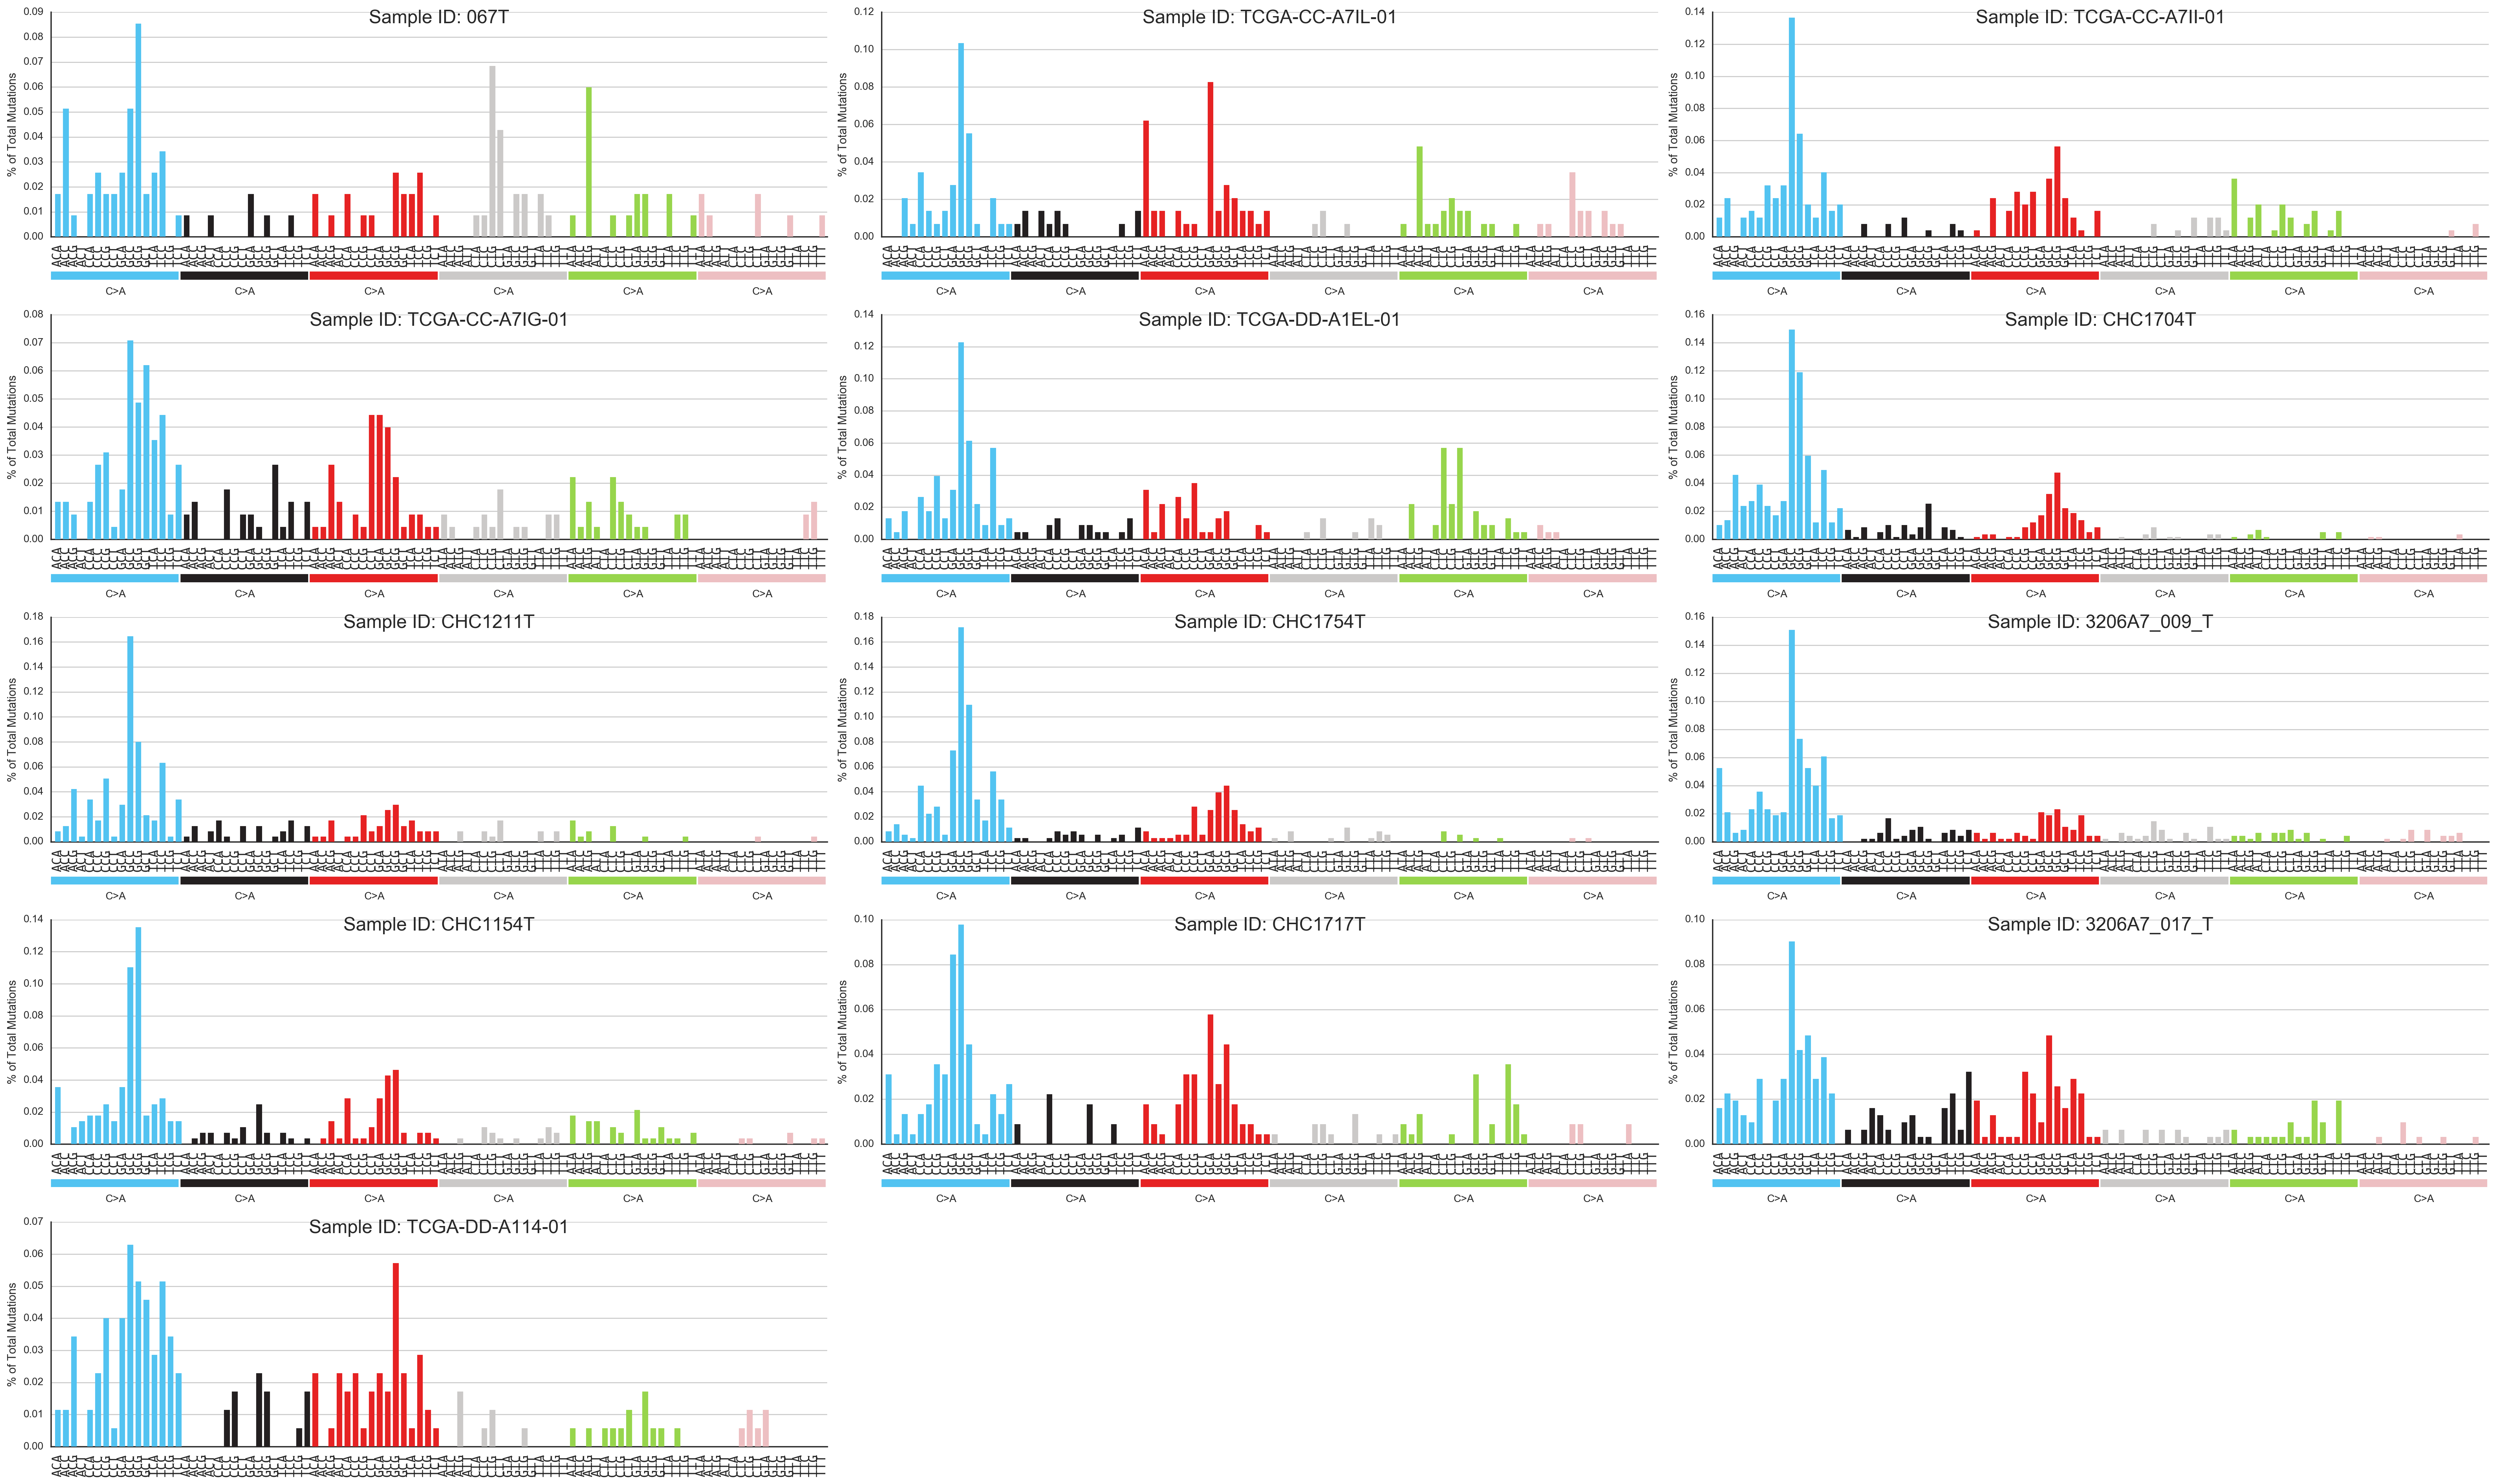

In [184]:
from varsig.figures import spectrum_map

py_labels, xlabels = zip(*selected_samples[0].spectrum_count.keys())

spectrum_map(3, 5, dpi=450,
             xlabels=[xlabels] * len(new_cluster),
             labels=py_labels,
             heights=[merged_samples[name].spectrum.normalized_proportion(exon_normal) for name in aflatoxin_cluster_names],
             titles=['Sample ID: {}\n'.format(x) for x in aflatoxin_cluster_names])

#plt.savefig('spectras.pdf', dpi=450)